In [2]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import hvplot.pandas
import geopandas as gpd

In [3]:
# Import the Health data
health_df = pd.read_csv('Source Data/HEALTH.csv')

# Import the tax data
tax_df = pd.read_csv('Source Data/TAXES.csv')

# Import the socioeconomic data
income_df = pd.read_csv('Source Data/SOCIOECONOMIC.csv')

# Calculate a new field of change in obesity from the 2017 and 2012 data
health_df['Change in Adult Obesity Percentage'] = health_df['PCT_OBESE_ADULTS17'] - health_df['PCT_OBESE_ADULTS12']

# Calculate sort data by the newly created change in obesity field
health_df = health_df.sort_values(['Change in Adult Obesity Percentage'], ascending=False)

# concatenate the two county and state in each dataframe
health_df['County and State Key'] = health_df['County'] + ", " + health_df['State']

tax_df['County and State Key'] = tax_df['County'] + ", " + tax_df['State']

income_df['County and State Key'] = income_df['County'] + ", " + income_df['State']

# Merge data into one dataframe
health_and_tax_df = pd.merge(health_df,tax_df,on='County and State Key',how='inner')

health_tax_inc_df = pd.merge(health_and_tax_df,income_df,on='County and State Key',how='inner')

# drop any incomplete rows so we can work with a complete set
health_tax_inc_df = health_tax_inc_df.dropna()

# Drop any rows that have a soda tax of zero
health_tax_inc_df = health_tax_inc_df.loc[~(health_tax_inc_df['SODATAX_STORES14'] == 0),:]

In [4]:
# Bin the data into groups

# Find max income for bins
max_inc = health_tax_inc_df['MEDHHINC15'].max()

# Bins and Labels
income_bins = [0,42508,51294,130000]
bin_labels = ['Low','Medium','High']

# Create bins
health_tax_inc_df['Income Bracket'] = pd.cut(health_tax_inc_df['MEDHHINC15'], bins=income_bins,labels=bin_labels)

# Test to make sure bins worked
test_df = health_tax_inc_df[['Income Bracket','MEDHHINC15']]

test_df = test_df.groupby('Income Bracket',observed=False)['MEDHHINC15'].max()


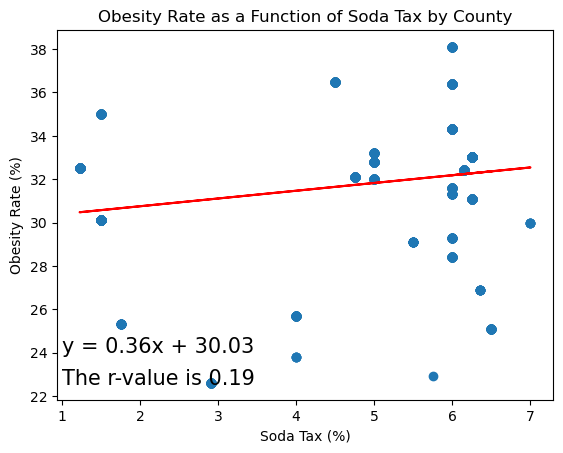

In [30]:
# scatterplot of soda tax and obesity rate and find a line of best fit

obesity = health_tax_inc_df['PCT_OBESE_ADULTS17']

soda_tax = health_tax_inc_df['SODATAX_STORES14']

# Linear Regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(soda_tax,obesity)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
regress_values = soda_tax * slope + intercept

rvalue = round(rvalue,2)

# plot

plt.scatter(soda_tax,obesity)
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Obesity Rate as a Function of Soda Tax by County')
plt.annotate(line_eq,(1,24),fontsize=15,color="black")
plt.annotate((f"The r-value is {rvalue}"),(1,22.5), fontsize=15, color="black")
plt.plot(soda_tax,regress_values,'r-')


plt.savefig('Obesity Rate as a Function of Soda Tax.png')
plt.show()

# bin the data and add the income level to the dataset for the county, adding in the socioeconomic data

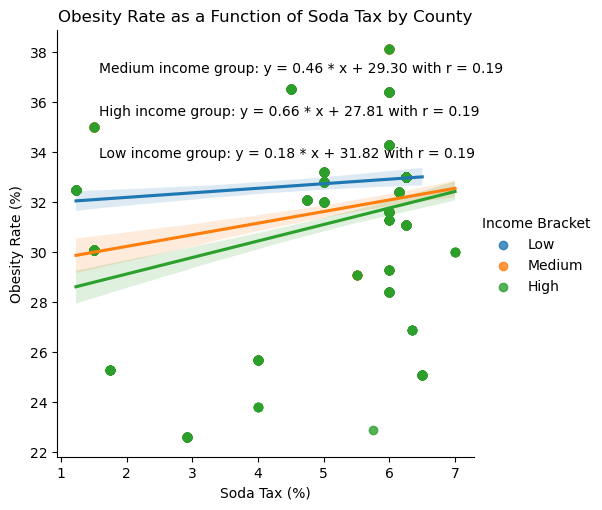

In [6]:
# Create a chart showing the relationship between soda tax and obesity at different income levels
#sns.scatterplot(x='SODATAX_STORES14',y='PCT_OBESE_ADULTS17',hue='Income Bracket', data=health_tax_inc_df)
sns.lmplot(x='SODATAX_STORES14',y='PCT_OBESE_ADULTS17',hue='Income Bracket', data=health_tax_inc_df)

# Get the linear regression parameters for each group
groups = health_tax_inc_df['Income Bracket'].unique()

for group in groups:
    group_data = health_tax_inc_df[health_tax_inc_df['Income Bracket'] == group]
    slope, intercept, r_value, p_value, std_err = linregress(group_data['SODATAX_STORES14'], group_data['PCT_OBESE_ADULTS17'])
    
    # Store equation for each group
    Equation = f"{group} income group: y = {slope:.2f} * x + {intercept:.2f} with r = {round(rvalue,2)}"
    
    # Annotate the plot with the equation
    plt.annotate(Equation, xy=(0.1, 0.9 - 0.1 * groups.tolist().index(group)), xycoords='axes fraction', fontsize=10)

plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Obesity Rate as a Function of Soda Tax by County')
plt.show()


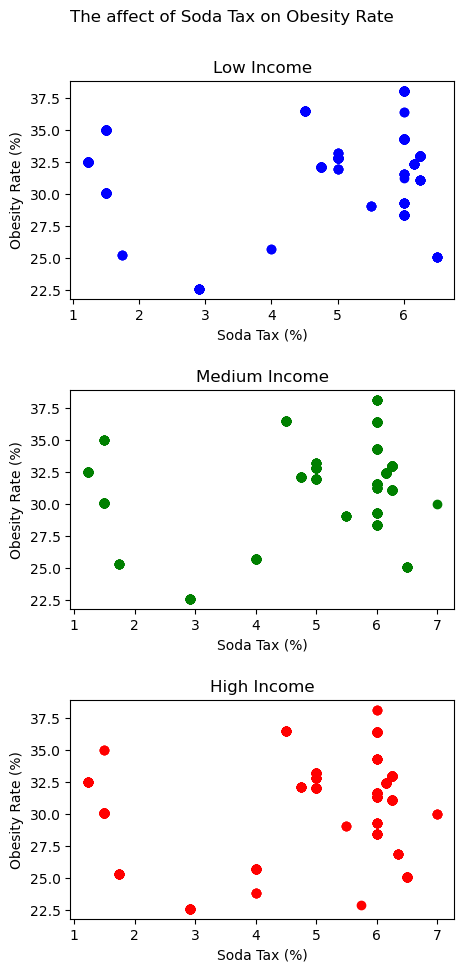

In [7]:
obesity_low = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'Low'),'PCT_OBESE_ADULTS17']

soda_tax_low = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'Low'),'SODATAX_STORES14']

obesity_med = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'Medium'),'PCT_OBESE_ADULTS17']

soda_tax_med = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'Medium'),'SODATAX_STORES14']

obesity_high = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'High'),'PCT_OBESE_ADULTS17']

soda_tax_high = health_tax_inc_df.loc[(health_tax_inc_df['Income Bracket'] == 'High'),'SODATAX_STORES14']

plt.figure(figsize=(5, 10))

plt.subplot(3,1,1)
plt.scatter(soda_tax_low,obesity_low,color='blue')
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Low Income')


plt.subplot(3,1,2)
plt.scatter(soda_tax_med,obesity_med,color='green')
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Medium Income')

plt.subplot(3,1,3)
plt.scatter(soda_tax_high,obesity_high,color='red')
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('High Income')

plt.suptitle('The affect of Soda Tax on Obesity Rate')
plt.tight_layout(pad=2.0)
plt.show()

In [8]:
# Group Key fields by state for better figures

soda_tax_by_st = health_tax_inc_df.groupby('State')['SODATAX_STORES14'].mean()

avg_obesity_by_st = health_tax_inc_df.groupby('State')['PCT_OBESE_ADULTS17'].mean()

avg_med_inc_by_st = health_tax_inc_df.groupby('State')['MEDHHINC15'].mean()

state_df = pd.DataFrame({"Soda Tax in Stores (%)": soda_tax_by_st,
                       "Average Obesity (%)":avg_obesity_by_st,
                       "Average Median Income ($)":avg_med_inc_by_st})

state_df.head()

,Soda Tax in Stores (%),Average Obesity (%),Average Median Income ($)
State,,,
AR,1.50,35.0,38984.194030
CA,6.50,25.1,57765.543860
CO,2.91,22.6,54271.983871
CT,6.35,26.9,72445.125000
DC,5.75,22.9,73115.000000


In [9]:
# Bin the new dataframe
# Find max income for bins
max_inc = state_df['Average Median Income ($)'].max()

# Bins and Labels
income_bins = [0,47000,56000,130000]
bin_labels = ['Low','Medium','High']

# Create bins
state_df['Income Bracket'] = pd.cut(state_df['Average Median Income ($)'], bins=income_bins,labels=bin_labels)

# Test to make sure bins worked
test_df = state_df[['Income Bracket','Average Median Income ($)']]

test_df = test_df.groupby('Income Bracket',observed=False)['Average Median Income ($)'].count()

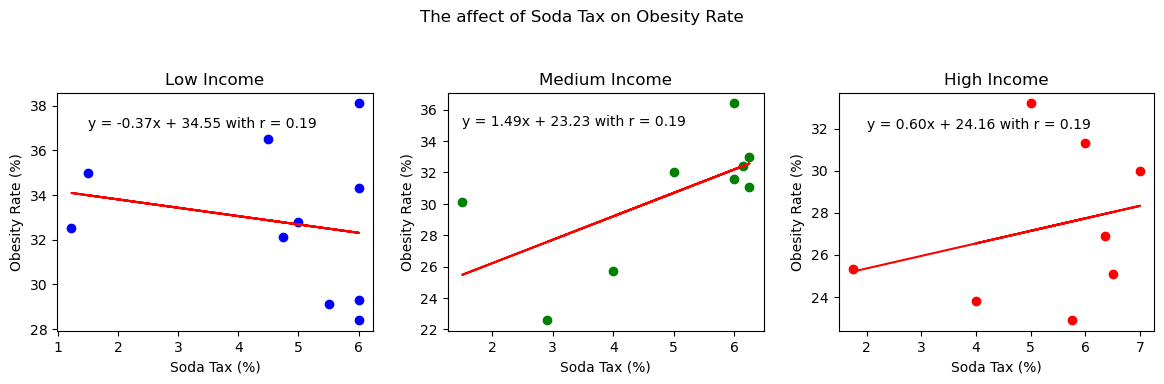

In [33]:
# create series of each income bracket for charts

obesity_low = state_df.loc[(state_df['Income Bracket'] == 'Low'),'Average Obesity (%)']

soda_tax_low = state_df.loc[(state_df['Income Bracket'] == 'Low'),'Soda Tax in Stores (%)']

obesity_med = state_df.loc[(state_df['Income Bracket'] == 'Medium'),'Average Obesity (%)']

soda_tax_med = state_df.loc[(state_df['Income Bracket'] == 'Medium'),'Soda Tax in Stores (%)']

obesity_high = state_df.loc[(state_df['Income Bracket'] == 'High'),'Average Obesity (%)']

soda_tax_high = state_df.loc[(state_df['Income Bracket'] == 'High'),'Soda Tax in Stores (%)']

# Create lin reg equation for each chart
groups = state_df['Income Bracket'].unique()


# Create empty lists to store
equation_list = []

equation_line = []

# Loop through groups to store equations and lines to put on sublot
for group in groups:
    group_data = state_df[state_df['Income Bracket'] == group]
    slope, intercept, r_value, p_value, std_err = linregress(group_data['Soda Tax in Stores (%)'], group_data['Average Obesity (%)'])
    
    x_values = group_data['Soda Tax in Stores (%)']
    
    # Build equation for each group
    Equation = f"y = {slope:.2f}x + {intercept:.2f} with r = {round(rvalue,2)}"
    
    line = x_values * slope + intercept
    
    # store equation in list
    equation_list.append(Equation)
    equation_line.append(line)
    
# Create Subplots

# Figure Size
plt.figure(figsize=(12, 4))

# Subplot 1
plt.subplot(1,3,1)
plt.scatter(soda_tax_low,obesity_low,color='blue')
plt.annotate(equation_list[0],(1.5,37),fontsize=10,color="black")
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Low Income')
plt.plot(soda_tax_low,equation_line[0],'r-')


# Subplot 2
plt.subplot(1,3,2)
plt.scatter(soda_tax_med,obesity_med,color='green')
plt.annotate(equation_list[2],(1.5,35),fontsize=10,color="black")
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('Medium Income')
plt.plot(soda_tax_med,equation_line[2],'r-')

# Subplot 3
plt.subplot(1,3,3)
plt.scatter(soda_tax_high,obesity_high,color='red')
plt.annotate(equation_list[1],(2,32),fontsize=10,color="black")
plt.xlabel('Soda Tax (%)')
plt.ylabel('Obesity Rate (%)')
plt.title('High Income')
plt.plot(soda_tax_high,equation_line[1],'r-')


# Add overall title
plt.suptitle('The affect of Soda Tax on Obesity Rate')
plt.tight_layout(pad=2.0)

# Save plot
plt.savefig('Affect of Soda Tax on Obesity Rate.png')

# Show Plot
plt.show()